### Loading the data

In [1]:
import json
import pandas as pd
import numpy as np



# Loading data


with open('../StatsBomb/Data/FAWSL_22_23.json') as data_file:    
    data = json.load(data_file)  

fawsl = pd.json_normalize(data).sort_values('match_date')



events = pd.DataFrame()
lineups = pd.DataFrame()
lineups_positions = pd.DataFrame()
lineups_events = pd.DataFrame()


matches = {'Arsenal' : 3852832,
           'AstonVilla' : 3856030,
           'Brighton' : 3855980,
           'LeicesterCity' : 3855947,
           'Liverpool' : 3855961,
           'Tottenham' : 3856040}


for i in matches:
    
    with open('../StatsBomb/Data/ManCity_' + i + '_events.json') as data_file:    
        data = json.load(data_file)
    normalized_data = pd.json_normalize(data).sort_values(['minute', 'second'])
    normalized_data['match_id'] = matches[i]
    events = pd.concat([events, normalized_data])

    
    with open('../StatsBomb/Data/ManCity_' + i + '_lineups.json') as data_file:    
        data = json.load(data_file)
        
    # Unnesting lineups
    normalized_data = pd.json_normalize(data,
                                        record_path='lineup',
                                        meta = ['team_id', 'team_name'])
    normalized_data['match_id'] = matches[i]
    lineups = pd.concat([lineups, normalized_data])
        
    # Unnesting positions
    normalized_data = pd.json_normalize(data,
                                        record_path=['lineup', 'positions'],
                                        meta = ['team_id', 'team_name',
                                                ['lineup', 'player_id'],
                                                ['lineup', 'player_name'],
                                                ['lineup', 'player_nickname']])
    normalized_data['match_id'] = matches[i]
    lineups_positions = pd.concat([lineups_positions, normalized_data])
    
    # Unnesting events
    normalized_data = pd.json_normalize(data, record_path=['events'], meta = ['team_id', 'team_name'])
    normalized_data['match_id'] = matches[i]
    lineups_events = pd.concat([lineups_events, normalized_data])
    
    # Unnesting formations: pd.json_normalize(data, record_path=['formations'], meta = ['team_id', 'team_name',])



# Convert column from object to int

lineups_positions = lineups_positions.astype({'lineup.player_id': 'int'})
    
    
## Add home and away team ids for each event
    
events = events.merge(fawsl[['match_id', 'home_team.home_team_id', 'away_team.away_team_id']],
                      how='left')


## Add opponent team id for each event

events['opponent.id'] = np.where(events['team.id'] == events['home_team.home_team_id'],
                                 events['away_team.away_team_id'],
                                 events['home_team.home_team_id'])



## Add the current score


# Flag all goals (Shot + Own Goal For)

events.loc[(events['shot.outcome.id'] == 97) | (events['type.id'] == 25), 'goal'] = 1
events['goal'] = events['goal'].fillna(0)



# Add score (goals for and against) at any time during the game

home = (events['team.id'] == events['home_team.home_team_id'])
away = (events['team.id'] == events['away_team.away_team_id'])

events.loc[home, 'home_team.goals'] = events[home].groupby(['match_id', 'team.id'])['goal'].cumsum()
events.loc[away, 'away_team.goals'] = events[away].groupby(['match_id', 'team.id'])['goal'].cumsum()

events['home_team.goals'] = events['home_team.goals'].fillna(method='ffill').fillna(0)
events['away_team.goals'] = events['away_team.goals'].fillna(method='ffill').fillna(0)

events['GF'] = np.where(home,
                        events['home_team.goals'],
                        events['away_team.goals'])

events['GA'] = np.where(home,
                        events['away_team.goals'],
                        events['home_team.goals'])



## Add cumulative xG (for and against) at any time during the game

events.loc[home, 'home_team.xg'] = events[home].fillna({'shot.statsbomb_xg':0}).groupby(
    ['match_id', 'team.id'])['shot.statsbomb_xg'].cumsum()
events.loc[away, 'away_team.xg'] = events[away].fillna({'shot.statsbomb_xg':0}).groupby(
    ['match_id', 'team.id'])['shot.statsbomb_xg'].cumsum()

events['home_team.xg'] = events['home_team.xg'].fillna(method='ffill').fillna(0)
events['away_team.xg'] = events['away_team.xg'].fillna(method='ffill').fillna(0)

events['xgF'] = np.where(home,
                        events['home_team.xg'],
                        events['away_team.xg'])

events['xgA'] = np.where(home,
                        events['away_team.xg'],
                        events['home_team.xg'])



## Add status (win / draw / loose), goal and xG differences

events.loc[events['GF']>events['GA'], 'status'] = 'W'
events.loc[events['GF']==events['GA'], 'status'] = 'D'
events.loc[events['GF']<events['GA'], 'status'] = 'L'
events['GD'] = events['GF'] - events['GA']
events['xgD'] = events['xgF'] - events['xgA']


print(fawsl.columns)

len(fawsl)

# 12 teams # 22*6

/var/folders/q1/wzhp06ks1g91z4q1dgtf50xr0000gn/T/ipykernel_56136/2940911376.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events['opponent.id'] = np.where(events['team.id'] == events['home_team.home_team_id'],
/var/folders/q1/wzhp06ks1g91z4q1dgtf50xr0000gn/T/ipykernel_56136/2940911376.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events.loc[(events['shot.outcome.id'] == 97) | (events['type.id'] == 25), 'goal'] = 1


Index(['match_id', 'match_date', 'kick_off', 'home_score', 'away_score',
       'attendance', 'behind_closed_doors', 'neutral_ground', 'play_status',
       'match_status', 'match_status_360', 'last_updated', 'last_updated_360',
       'match_week', 'competition.competition_id', 'competition.country_name',
       'competition.competition_name', 'season.season_id',
       'season.season_name', 'home_team.home_team_id',
       'home_team.home_team_name', 'home_team.home_team_gender',
       'home_team.home_team_youth', 'home_team.home_team_group',
       'home_team.country.id', 'home_team.country.name', 'home_team.managers',
       'away_team.away_team_id', 'away_team.away_team_name',
       'away_team.away_team_gender', 'away_team.away_team_youth',
       'away_team.away_team_group', 'away_team.country.id',
       'away_team.country.name', 'away_team.managers', 'metadata.data_version',
       'metadata.shot_fidelity_version', 'metadata.xy_fidelity_version',
       'competition_stage.id'

132

# Data exploration

## Indentifying the games

In [2]:
# lineups_events[lineups_events['match']=='AstonVilla']
# lineups_events[lineups_events['match']=='LeicesterCity']
# lineups_events[lineups_events['match']=='Tottenham']

fawsl[(fawsl['home_team.home_team_name'] == 'Manchester City WFC') |
      (fawsl['away_team.away_team_name'] == 'Manchester City WFC')][['match_id',
                                                                     'match_date',
                                                                     'home_team.home_team_id',
                                                                     'home_team.home_team_name',
                                                                     'home_score',
                                                                     'away_team.away_team_name',
                                                                     'away_score']]

fawsl[fawsl['match_id'].isin(matches.values())][['match_id', 'match_date',
                                                 'home_team.home_team_id', 'home_team.home_team_name',
                                                 'home_score',
                                                 'away_team.away_team_id', 'away_team.away_team_name',
                                                 'away_score']]

# All the games are played at home, so we don't add this feature into our model

,match_id,match_date,home_team.home_team_id,home_team.home_team_name,home_score,away_team.away_team_id,away_team.away_team_name,away_score
124,3855947,2022-10-16,746,Manchester City WFC,4.0,2652,Leicester City WFC,0.0
46,3855961,2022-10-30,746,Manchester City WFC,2.0,966,Liverpool WFC,1.0
108,3855980,2022-12-04,746,Manchester City WFC,3.0,965,Brighton & Hove Albion WFC,1.0
21,3856030,2023-01-21,746,Manchester City WFC,1.0,2647,Aston Villa,1.0
129,3852832,2023-02-11,746,Manchester City WFC,2.0,968,Arsenal WFC,1.0
13,3856040,2023-03-05,746,Manchester City WFC,3.0,749,Tottenham Hotspur Women,1.0


In [3]:
events.head()

# events['match'].nunique(), lineups['match'].nunique()

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,away_team.goals,GF,GA,home_team.xg,away_team.xg,xgF,xgA,status,GD,xgD
0,5ab3a8e3-e6e1-4a94-b057-57b2301abac5,1,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0
1,15347fb5-bd07-47c7-9331-b5d0d6901847,2,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0
2,7b3793be-f0aa-40b5-aedf-e2ec45e43069,3,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0
3,b3f6b437-6189-49a7-84b3-06992c851d5d,4,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0
4,edbc9819-3d24-4c37-adc0-06949261903b,5,1,00:00:00.280,0,0,2,0.015265,0.007439,0.007826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0


In [4]:
lineups.head()

,player_id,player_name,player_nickname,birth_date,player_gender,player_height,player_weight,jersey_number,positions,country.id,...,stats.own_goals,stats.goals,stats.assists,stats.penalties_scored,stats.penalties_missed,stats.penalties_saved,stats,team_id,team_name,match_id
0,4637,Ellie Roebuck,None,1999-09-23,female,174.0,58.0,1,"[{'position_id': 1, 'position': 'Goalkeeper', ...",68,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,746,Manchester City WFC,3852832
1,6818,Hayley Emma Raso,None,1994-09-05,female,161.0,60.0,13,"[{'position_id': 17, 'position': 'Right Wing',...",14,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,746,Manchester City WFC,3852832
2,10163,Leila Ouahabi El Ouahabi,Leila Ouahabi,1993-03-22,female,171.0,58.0,15,[],214,...,NaN,NaN,NaN,NaN,NaN,NaN,[],746,Manchester City WFC,3852832
3,10185,Stephanie Houghton,None,1988-04-23,female,174.0,60.0,6,"[{'position_id': 3, 'position': 'Right Center ...",68,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,746,Manchester City WFC,3852832
4,10252,Alex Greenwood,None,1993-09-07,female,168.0,62.0,5,"[{'position_id': 5, 'position': 'Left Center B...",68,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,746,Manchester City WFC,3852832


In [5]:
print(*events.columns, sep='\n')

id
index
period
timestamp
minute
second
possession
obv_for_after
obv_for_before
obv_for_net
obv_against_after
obv_against_before
obv_against_net
obv_total_net
duration
type.id
type.name
possession_team.id
possession_team.name
play_pattern.id
play_pattern.name
team.id
team.name
tactics.formation
tactics.lineup
related_events
location
player.id
player.name
position.id
position.name
pass.recipient.id
pass.recipient.name
pass.length
pass.angle
pass.height.id
pass.height.name
pass.end_location
pass.type.id
pass.type.name
pass.body_part.id
pass.body_part.name
carry.end_location
under_pressure
pass.outcome.id
pass.outcome.name
ball_receipt.outcome.id
ball_receipt.outcome.name
counterpress
duel.type.id
duel.type.name
miscontrol.aerial_won
pass.aerial_won
dribble.outcome.id
dribble.outcome.name
pass.switch
interception.outcome.id
interception.outcome.name
shot.statsbomb_xg
shot.end_location
shot.outcome.id
shot.outcome.name
shot.technique.id
shot.technique.name
shot.body_part.id
shot.body_part.

In [6]:
events.obv_total_net.describe()

count    12224.000000
mean         0.002128
std          0.041380
min         -0.921505
25%         -0.001667
50%          0.000181
75%          0.003264
max          0.951513
Name: obv_total_net, dtype: float64

In [7]:
events.groupby(['team.name', 'player.name', 'position.name'])['obv_total_net'].sum().sort_values()

team.name                   player.name          position.name      
Manchester City WFC         Ellie Roebuck        Goalkeeper            -2.224780
Tottenham Hotspur Women     Ashleigh Neville     Left Wing Back        -0.610430
Brighton & Hove Albion WFC  Danielle Carter      Left Center Forward   -0.530052
Leicester City WFC          Sophie Howard        Right Center Back     -0.371033
Aston Villa                 Alisha Lehmann       Left Wing             -0.334410
                                                                          ...   
Liverpool WFC               Rachael Laws         Goalkeeper             1.240532
Manchester City WFC         Khadija Monifa Shaw  Center Forward         1.975075
                            Alex Greenwood       Left Center Back       2.655678
                            Lauren Hemp          Left Wing              3.176667
                            Chloe Kelly          Right Wing             3.628667
Name: obv_total_net, Length: 138, dtype:

In [8]:
#https://www.football.london/womens-football/arsenal-women-ratings-man-city-26215572

# No rating: Frida Maanum

# Lotte Wubben-Moy 4
# Noelle Maritz 4
# Lia Walti 4

# Manuela Zinsberger 5
# Leah Williamson 5
# Kim Little 5
# Steph Catley 5
# Caitlin Foord 5
# Stina Blackstenius 5
# Victoria Pelova 5
# Katie McCabe 5

# Rafaelle Souza 6

### ManCity players position

In [10]:
events[events['team.id'] == 746].groupby(
        'player.id').aggregate({'position.id': pd.Series.mode}).sort_values('position.id').reset_index(
).merge(lineups[['player_id','player_name']].rename(columns={'player_id': 'player.id'}),
           how='left').drop_duplicates()

,player.id,position.id,player_name
0,4637.0,1.0,Ellie Roebuck
6,221888.0,2.0,Kerstin Yasmijn Casparij
12,5078.0,3.0,Alanna Stephanie Kennedy
14,10185.0,3.0,Stephanie Houghton
20,32210.0,3.0,Laia Aleixandri López
26,10252.0,5.0,Alex Greenwood
32,4651.0,6.0,Demi Stokes
36,10163.0,6.0,Leila Ouahabi El Ouahabi
42,4649.0,6.0,Esme Beth Morgan
47,41812.0,10.0,Ruby Mace


## Looking at OBV over time

<AxesSubplot:xlabel='Minute', ylabel='Cumulative OBV'>

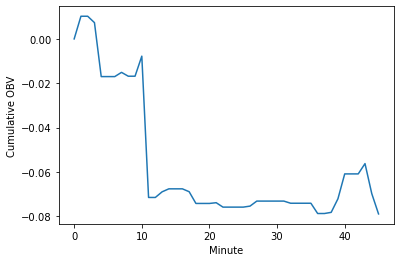

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
events[(events['match_id'] == 3856030) &
       (events['minute']<45) &
       (events['player.id']==15570)].groupby('minute')['obv_total_net'].fillna(0).cumsum().set_axis(
    np.arange(46)).plot(xlabel = 'Minute', ylabel = 'Cumulative OBV',
                       ax=ax)

<AxesSubplot:xlabel='minute'>

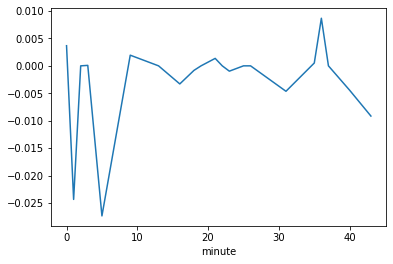

In [23]:
events[(events['match_id'] == 3856030) &
                        (events['minute']<45) &
                        (events['player.id']==15570)
                       ].groupby('minute')['obv_total_net'].mean().fillna(0).plot()

<AxesSubplot:xlabel='minute'>

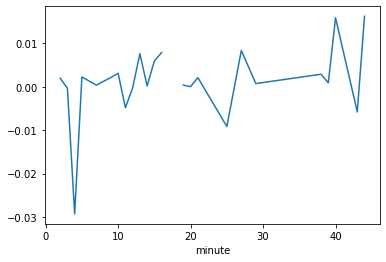

In [25]:
events[(events['match_id'] == 3856030) &
                        (events['minute']<45) &
                        (events['player.id']==10252)
                       ].groupby('minute')['obv_total_net'].mean().plot()

## Models

### Model not retained

In [74]:
#Building the Decision Tree Model on our dataset
#from sklearn.tree import DecisionTreeRegressor
#DT_model = DecisionTreeRegressor(max_depth=10).fit(X_train,Y_train)

#DT_predict = DT_model.predict(X_test) #Predictions on Testing data
#print(DT_predict)
#np.unique(DT_predict)

In [1384]:
#DT_model.score(X_train,Y_train)

0.9987162011874539

In [76]:
# Building the KNN Model on our dataset
#from sklearn.neighbors import KNeighborsRegressor
#KNN_model = KNeighborsRegressor(n_neighbors=3).fit(X_train,Y_train)
#KNN_predict = KNN_model.predict(X_test) #Predictions on Testing data
#print(KNN_predict)
#np.unique(KNN_predict)

In [59]:
predict_best_subs(45).loc[2]

player_name_off             Alex Greenwood
position_off                             5
player_name_in          Stephanie Houghton
position_in                              3
possible_position_in            [3.0, 5.0]
predicted_obv                     0.346324
Name: 2, dtype: object

### Linear regression

Technical assumptions: we assume we have data flux every minute.

In [13]:
import os
os.chdir('..')

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import streamlit as st
from PIL import Image

from load_data import fawsl, events, lineups, lineups_positions, matches, position, subs, columns, categorical, ohe, explanation
from functions import preprocessing, predict_best_subs, stats_player, highlight



### Model

## Prepare training dataset

train = subs[subs['match_id'] != matches['AstonVilla']] # Exclude AstonVilla game from the training dataset
X_train = train[columns]
Y_train = train['obv_in']


## One hot encoding

# get_dummies : not the same number of features in train and test data: https://stackoverflow.com/questions/67865253/valueerror-x-has-10-features-but-decisiontreeclassifier-is-expecting-11-featur
train_array_hot_encoded = ohe.fit_transform(X_train[categorical])
X_train = preprocessing(train_array_hot_encoded, X_train)

model = make_pipeline(StandardScaler(with_mean=False),
                      LinearRegression())
model.fit(X_train, Y_train)

/Users/juliette/Documents/Travail/Hays x Man City Football Club Hackathon 2023/Man-City-Hackathon/load_data.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events['opponent.id'] = np.where(events['team.id'] == events['home_team.home_team_id'],
/Users/juliette/Documents/Travail/Hays x Man City Football Club Hackathon 2023/Man-City-Hackathon/load_data.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events.loc[(events['shot.outcome.id'] == 97) | (events['type.id'] == 25), 'goal'] = 1
/Users/juliette/Documents/Travail/Hays

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearregression', LinearRegression())])

### Data exploration: looking at subs

In [27]:
print(len(subs))
# 40 pour 6 matchs : 6.6 changements par match

subs[['match_id', 'index', 'minute', 'second', 'team.id', 'opponent.id',
      'GF', 'GA', 'GD', 'status',
      'xgF', 'xgA', 'xgD',
      'player.id', 'position_off', 'obv_off', 'obv_off_match', # 'player.name',
      'substitution.replacement.id', 'position_in', 'sum_obv_in', 'obv_in',
      'obv']].head()

40


,match_id,index,minute,second,team.id,opponent.id,GF,GA,GD,status,...,xgD,player.id,position_off,obv_off,obv_off_match,substitution.replacement.id,position_in,sum_obv_in,obv_in,obv
0,3852832,1896,45,0,968,746,0.0,2.0,-2.0,L,...,-1.708122,11338,21,-0.005920,-0.005920,15620,21,0.020641,0.020641,0.026561
1,3852832,1897,45,0,968,746,0.0,2.0,-2.0,L,...,-1.708122,49697,4,0.117747,0.117747,10405,4,0.228870,0.228870,0.111122
2,3852832,2759,67,58,968,746,1.0,2.0,-1.0,L,...,-1.635886,63788,16,-0.036522,-0.036522,276443,16,0.018462,0.018462,0.054984
3,3852832,3158,80,6,968,746,1.0,2.0,-1.0,L,...,-1.795885,10404,2,0.090278,0.090278,46973,2,0.026878,0.026878,-0.063401
4,3852832,3159,80,19,968,746,1.0,2.0,-1.0,L,...,-1.795885,10229,22,-0.221350,-0.221350,45294,22,-0.069352,-0.069352,0.151998


In [28]:
subs[subs.duplicated(['match_id', 'substitution.replacement.id'], keep=False)]

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,obv_off,xg,shots,pressures,fouls_won,fouls_committed,passing,interceptions,minutes,sum_obv_in


In [15]:
print(len(subs[subs['obv']>0]), len(subs[subs['obv']<0]))

16 24


## Analysing model: Interpretability

In [14]:
import eli5

eli5.show_weights(model, feature_names = list(X_train.columns))

Weight?,Feature
+0.071,status_D
+0.040,substitution.replacement.id_49938
+0.031,obv_off_match
+0.025,sum_obv_in
+0.021,xgF
+0.019,opponent.id_965
+0.015,position_in_17
+0.015,position_off_17
+0.015,substitution.replacement.id_31551
+0.014,player.id_21048


In [40]:
import shap

# Need to load JS visualisation in the notebook
shap.initjs()

explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

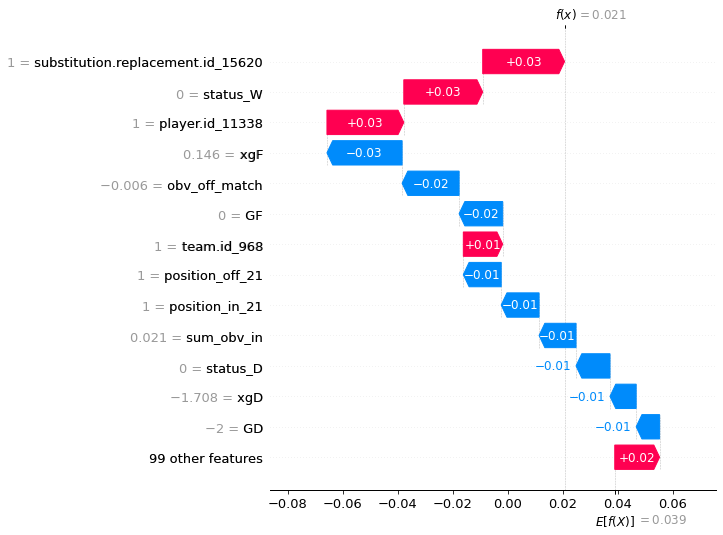

In [41]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[0], max_display=14)

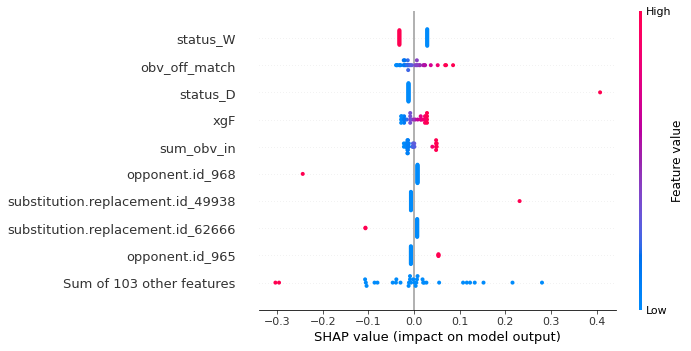

In [37]:
shap.plots.beeswarm(shap_values)

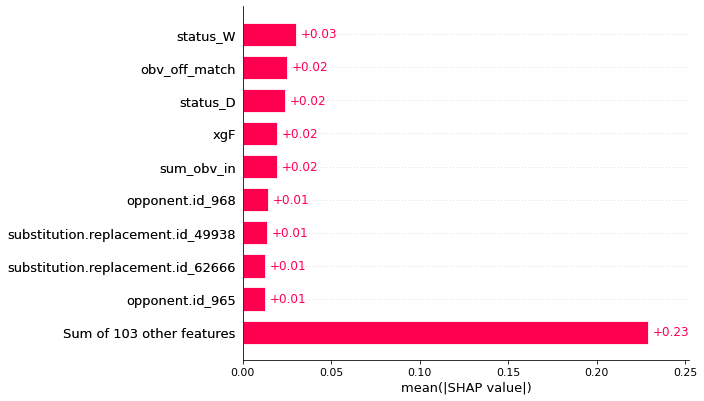

In [38]:
shap.plots.bar(shap_values)

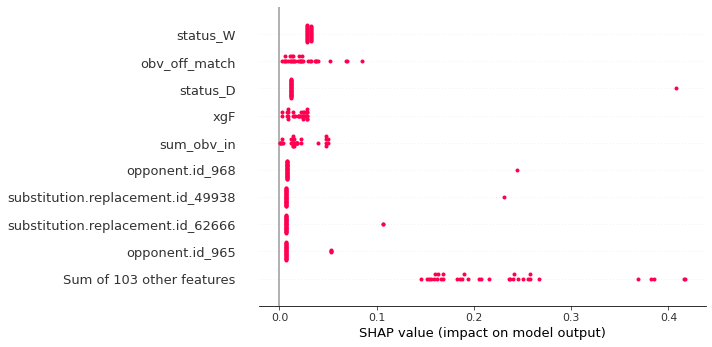

In [39]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

## Comparing predicted values with actual performance values

In [46]:
events[events['match_id'] == matches['AstonVilla']].groupby(
    'player.name')['obv_total_net'].sum()

player.name
Alanna Stephanie Kennedy               0.258851
Alex Greenwood                         0.145957
Alisha Lehmann                        -0.362167
Anna Jessica Leat                      0.163154
Anna Patten                            0.164434
Chloe Kelly                            0.278255
Danielle Turner                        0.036428
Deyna Cristina Castellanos Naujenis    0.504415
Ellie Roebuck                         -0.664386
Esme Beth Morgan                      -0.041979
Hayley Emma Raso                       0.163266
Ingrid Filippa Angeldal               -0.098495
Jordan Nobbs                          -0.208024
Kenza Dali                            -0.034282
Kerstin Yasmijn Casparij               0.175550
Khadija Monifa Shaw                   -0.248294
Kirsty Hanson                         -0.286923
Laura Coombs                          -0.084552
Laura Madison Blindkilde Brown         0.126593
Lauren Hemp                            0.479336
Leila Ouahabi El Ouahabi    

In [21]:
events[events['minute']<67].groupby(['match_id', 'player.id'])['obv_total_net'].sum().reset_index().rename(
    columns={'obv_total_net': 'obv_off_match'})

,match_id,player.id,obv_off_match
0,3852832,4637.0,-0.739294
1,3852832,5000.0,0.051855
2,3852832,10185.0,0.089119
3,3852832,10229.0,-0.140558
4,3852832,10237.0,0.512682
...,...,...,...
139,3856040,31551.0,0.000000
140,3856040,32210.0,0.228847
141,3856040,62666.0,0.050765
142,3856040,63424.0,-0.210868
